In [1]:
import pytz
from datetime import datetime
from calc_utils import clear_biocredits_tables, download_kml_official, kml_to_shp, load_shp, normalize_shps, \
                       reorder_polygons, shp_to_land, plot_land, download_observations, observations_to_circles, \
                       expand_observations, daily_score_union, daily_video, daily_attibution, monthly_attribution, \
                       cummulative_attribution, insert_gdf_to_airtable, insert_log_entry, upload_to_gcs

In [2]:
colombia_tz = pytz.timezone('America/Bogota')
start_str = datetime.now(colombia_tz).strftime('%Y-%m-%d %H:%M:%S')
clear_biocredits_tables(["Logs", "Observations", "Monthly Attribution", "Cummulative Attribution"])
insert_log_entry('Start time', start_str)

In [2]:
# Download KMLs
download_kml_official()
# KML to SHP
kml_to_shp(source_directory='KML/', destination_directory='SHP/')

Downloaded plot_id 001
Downloaded plot_id 002
Downloaded plot_id 003
Downloaded plot_id 004
Downloaded plot_id 005
Downloaded plot_id 006
Downloaded plot_id 008
Downloaded plot_id 009
Downloaded plot_id 010
Downloaded plot_id 011
Downloaded plot_id 012
Downloaded plot_id 018
Downloaded plot_id 020
Downloaded plot_id 023
Downloaded plot_id 028
Downloaded plot_id 029
Downloaded plot_id 030
Downloaded plot_id 034
Downloaded plot_id 035
Downloaded plot_id 037
Downloaded plot_id 039
Downloaded plot_id 040
Downloaded plot_id 043
Downloaded plot_id 044
Downloaded plot_id 045
Downloaded plot_id 049
Downloaded plot_id 050
Downloaded plot_id 059
Downloaded plot_id 060
Downloaded plot_id 061
Downloaded plot_id 062
Downloaded plot_id 063
Downloaded plot_id 064
Downloaded plot_id 066
Downloaded plot_id 069
Downloaded plot_id 070
Downloaded plot_id 071
Downloaded plot_id 072
Downloaded plot_id 073
Downloaded plot_id 074
Downloaded plot_id 075
Downloaded plot_id 077
Downloaded plot_id 078
Downloaded 

Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 9 from 

Converted 178.kml to 178.shp
########## Converting 144 ##########
Converted 144.kml to 144.shp
########## Converting 150 ##########
Converted 150.kml to 150.shp
########## Converting 018 ##########
Converted 018.kml to 018.shp
########## Converting 030 ##########
Converted 030.kml to 030.shp
########## Converting 151 ##########
Converted 151.kml to 151.shp
########## Converting 179 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 19 from

Converted 179.kml to 179.shp
########## Converting 192 ##########
Converted 192.kml to 192.shp
########## Converting 186 ##########
Converted 186.kml to 186.shp
########## Converting 190 ##########
Converted 190.kml to 190.shp
########## Converting 184 ##########
Converted 184.kml to 184.shp
########## Converting 153 ##########
Converted 153.kml to 153.shp
########## Converting 185 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 13 from

Converted 185.kml to 185.shp
########## Converting 191 ##########
Converted 191.kml to 191.shp
########## Converting 181 ##########
Converted 181.kml to 181.shp
########## Converting 156 ##########
Converted 156.kml to 156.shp
########## Converting 142 ##########
Converted 142.kml to 142.shp
########## Converting 037 ##########
Converted 037.kml to 037.shp
########## Converting 023 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 16 from

Converted 023.kml to 023.shp
########## Converting 157 ##########
Converted 157.kml to 157.shp
########## Converting 180 ##########
Converted 180.kml to 180.shp
########## Converting 182 ##########
Converted 182.kml to 182.shp
########## Converting 141 ##########
Converted 141.kml to 141.shp
########## Converting 155 ##########
Converted 155.kml to 155.shp
########## Converting 169 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 23 from

Converted 169.kml to 169.shp
########## Converting 035 ##########
Converted 035.kml to 035.shp
########## Converting 009 ##########
Converted 009.kml to 009.shp
########## Converting 008 ##########
Converted 008.kml to 008.shp
########## Converting 020 ##########
Converted 020.kml to 020.shp
########## Converting 034 ##########
Converted 034.kml to 034.shp
########## Converting 168 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 7 from 

Converted 168.kml to 168.shp
########## Converting 154 ##########
Converted 154.kml to 154.shp
########## Converting 140 ##########
Converted 140.kml to 140.shp
########## Converting 183 ##########
Converted 183.kml to 183.shp
########## Converting 127 ##########
Converted 127.kml to 127.shp
########## Converting 091 ##########
Converted 091.kml to 091.shp
########## Converting 132 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 17 from

Converted 132.kml to 132.shp
########## Converting 118 ##########
Converted 118.kml to 118.shp
########## Converting 130 ##########
Converted 130.kml to 130.shp
########## Converting 124 ##########
Converted 124.kml to 124.shp
########## Converting 087 ##########
Converted 087.kml to 087.shp
########## Converting 093 ##########
Converted 093.kml to 093.shp
########## Converting 078 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 8 from 

Converted 078.kml to 078.shp
########## Converting 044 ##########
Converted 044.kml to 044.shp
########## Converting 050 ##########
Converted 050.kml to 050.shp
########## Converting 045 ##########
Converted 045.kml to 045.shp
########## Converting 092 ##########
Converted 092.kml to 092.shp
########## Converting 125 ##########
Converted 125.kml to 125.shp
########## Converting 131 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 13 from

Converted 131.kml to 131.shp
########## Converting 119 ##########
Converted 119.kml to 119.shp
########## Converting 135 ##########
Converted 135.kml to 135.shp
########## Converting 121 ##########
Converted 121.kml to 121.shp
########## Converting 082 ##########
Converted 082.kml to 082.shp
########## Converting 096 ##########
Converted 096.kml to 096.shp
########## Converting 069 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 14 from

Converted 069.kml to 069.shp
########## Converting 040 ##########
Error converting 040.kml to 040.shp
########## Converting 097 ##########
Converted 097.kml to 097.shp
########## Converting 122 ##########
Converted 122.kml to 122.shp
########## Converting 095 ##########
Converted 095.kml to 095.shp
########## Converting 081 ##########
Converted 081.kml to 081.shp
########## Converting 043 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 14 from

Converted 043.kml to 043.shp
########## Converting 094 ##########
Converted 094.kml to 094.shp
########## Converting 123 ##########
Converted 123.kml to 123.shp
########## Converting 106 ##########
Converted 106.kml to 106.shp
########## Converting 072 ##########
Converted 072.kml to 072.shp
########## Converting 066 ##########
Converted 066.kml to 066.shp
########## Converting 073 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 16 from

Converted 073.kml to 073.shp
########## Converting 098 ##########
Converted 098.kml to 098.shp
########## Converting 113 ##########
Converted 113.kml to 113.shp
########## Converting 139 ##########
Converted 139.kml to 139.shp
########## Converting 105 ##########
Converted 105.kml to 105.shp
########## Converting 059 ##########
Converted 059.kml to 059.shp
########## Converting 071 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 16 from

Converted 071.kml to 071.shp
########## Converting 070 ##########
Converted 070.kml to 070.shp
########## Converting 064 ##########
Converted 064.kml to 064.shp
########## Converting 138 ##########
Converted 138.kml to 138.shp
########## Converting 114 ##########
Converted 114.kml to 114.shp
########## Converting 128 ##########
Converted 128.kml to 128.shp
########## Converting 060 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 11 from

Converted 060.kml to 060.shp
########## Converting 074 ##########
Converted 074.kml to 074.shp
########## Converting 049 ##########
Converted 049.kml to 049.shp
########## Converting 075 ##########
Converted 075.kml to 075.shp
########## Converting 061 ##########
Error converting 061.kml to 061.shp
########## Converting 129 ##########
Converted 129.kml to 129.shp
########## Converting 115 ##########


ERROR 4: ERROR parsing kml KML/061.kml :not well-formed (invalid token) on line 1 at offset 2
FAILURE:
Unable to open datasource `KML/061.kml' with the following drivers.
  -> `FITS'
  -> `PCIDSK'
  -> `netCDF'
  -> `PDS4'
  -> `VICAR'
  -> `JP2OpenJPEG'
  -> `PDF'
  -> `MBTiles'
  -> `BAG'
  -> `EEDA'
  -> `OGCAPI'
  -> `ESRI Shapefile'
  -> `MapInfo File'
  -> `UK .NTF'
  -> `LVBAG'
  -> `OGR_SDTS'
  -> `S57'
  -> `DGN'
  -> `OGR_VRT'
  -> `Memory'
  -> `CSV'
  -> `NAS'
  -> `GML'
  -> `GPX'
  -> `LIBKML'
  -> `KML'
  -> `GeoJSON'
  -> `GeoJSONSeq'
  -> `ESRIJSON'
  -> `TopoJSON'
  -> `Interlis 1'
  -> `Interlis 2'
  -> `OGR_GMT'
  -> `GPKG'
  -> `SQLite'
  -> `WAsP'
  -> `PostgreSQL'
  -> `OpenFileGDB'
  -> `DXF'
  -> `CAD'
  -> `FlatGeobuf'
  -> `Geoconcept'
  -> `GeoRSS'
  -> `VFK'
  -> `PGDUMP'
  -> `OSM'
  -> `GPSBabel'
  -> `OGR_PDS'
  -> `WFS'
  -> `OAPIF'
  -> `EDIGEO'
  -> `SVG'
  -> `Idrisi'
  -> `XLS'
  -> `ODS'
  -> `XLSX'
  -> `Elasticsearch'
  -> `Carto'
  -> `AmigoClou

Converted 115.kml to 115.shp
########## Converting 117 ##########
Converted 117.kml to 117.shp
########## Converting 088 ##########
Converted 088.kml to 088.shp
########## Converting 077 ##########
Converted 077.kml to 077.shp
########## Converting 063 ##########
Converted 063.kml to 063.shp
########## Converting 062 ##########
Converted 062.kml to 062.shp
########## Converting 089 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 8 from 

Converted 089.kml to 089.shp
########## Converting 116 ##########
Converted 116.kml to 116.shp
########## Converting 159 ##########
Converted 159.kml to 159.shp
########## Converting 165 ##########
Converted 165.kml to 165.shp
########## Converting 171 ##########
Converted 171.kml to 171.shp
########## Converting 207 ##########
Converted 207.kml to 207.shp
########## Converting 039 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 7 from 

Converted 039.kml to 039.shp
########## Converting 011 ##########
Converted 011.kml to 011.shp
########## Converting 005 ##########
Converted 005.kml to 005.shp
########## Converting 004 ##########
Converted 004.kml to 004.shp
########## Converting 010 ##########
Converted 010.kml to 010.shp
########## Converting 206 ##########
Converted 206.kml to 206.shp
########## Converting 164 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 23 from

Converted 164.kml to 164.shp
########## Converting 158 ##########
Converted 158.kml to 158.shp
########## Converting 199 ##########
Converted 199.kml to 199.shp
########## Converting 166 ##########
Converted 166.kml to 166.shp
########## Converting 204 ##########
Converted 204.kml to 204.shp
########## Converting 006 ##########
Converted 006.kml to 006.shp
########## Converting 012 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 15 from

Converted 012.kml to 012.shp
########## Converting 173 ##########
Converted 173.kml to 173.shp
########## Converting 188 ##########
Converted 188.kml to 188.shp
########## Converting 177 ##########
Converted 177.kml to 177.shp
########## Converting 163 ##########
Converted 163.kml to 163.shp
########## Converting 201 ##########
Converted 201.kml to 201.shp
########## Converting 003 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 27 from

Converted 003.kml to 003.shp
########## Converting 002 ##########
Error converting 002.kml to 002.shp
########## Converting 200 ##########
Converted 200.kml to 200.shp
########## Converting 162 ##########
Converted 162.kml to 162.shp
########## Converting 176 ##########
Converted 176.kml to 176.shp
########## Converting 189 ##########
Converted 189.kml to 189.shp
########## Converting 174 ##########


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 22 from

Converted 174.kml to 174.shp
########## Converting 202 ##########
Converted 202.kml to 202.shp
########## Converting 028 ##########
Converted 028.kml to 028.shp
########## Converting 029 ##########
Converted 029.kml to 029.shp
########## Converting 001 ##########
Converted 001.kml to 001.shp
########## Converting 175 ##########
Converted 175.kml to 175.shp


Warning 6: Normalized/laundered field name: 'description' to 'descriptio'
Warning 1: The output driver does not natively support DateTime type for field timestamp. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field timestamp create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field begin. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field begin create as date field, though DateTime requested.
Warning 1: The output driver does not natively support DateTime type for field end. Misconversion can happen. -mapFieldType can be used to control field type conversion.
Warning 6: Field end create as date field, though DateTime requested.
Warning 6: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
ERROR 1: Attempt to write non-point (POLYGON) geometry to point shapefile.
ERROR 1: Unable to write feature 16 from

In [3]:
shp = load_shp('SHP/')
insert_log_entry('Number of fincas', str(len(shp)))

In [4]:
normalized_shapes = normalize_shps(shp)
gdf_normalized = shp_to_land(normalized_shapes)
plot_land(gdf_normalized, 'fincas0.html')
insert_log_entry('Fincas plot:', upload_to_gcs('biocredits-calc', 'fincas0.html', 'plots_without_reordering.html'))
reorder_lands = [] 
insert_log_entry('Reorder:', str(reorder_lands))
normalized_shapes_reordered = reorder_polygons(normalized_shapes, reorder_lands=reorder_lands)
lands = shp_to_land(normalized_shapes_reordered)
plot_land(lands, 'fincas1.html')
insert_log_entry('Fincas plot reordered:', upload_to_gcs('biocredits-calc', 'fincas1.html', 'plots_with_reordering.html'))


In [2]:
records = download_observations()
records = observations_to_circles(records, default_crs=4326, buffer_crs=6262)

insert_gdf_to_airtable(records, 'Observations', insert_geo = False, delete_all=True)

KeyboardInterrupt: 

In [6]:
obs_expanded = expand_observations(records)
daily_score = daily_score_union(obs_expanded)

Processing frame 0 with index 0
Processing frame 0 with index 0
Processing frame 100 with index 100
Processing frame 200 with index 200
Processing frame 300 with index 300
Processing frame 400 with index 400
Processing frame 500 with index 500
Processing frame 600 with index 600
Processing frame 700 with index 700
Processing frame 800 with index 800
Processing frame 900 with index 900
Processing frame 1000 with index 1000
Processing frame 1100 with index 1100
Processing frame 1200 with index 1200
Processing frame 1300 with index 1300
Processing frame 1400 with index 1400
Processing frame 1500 with index 1500
Processing frame 1600 with index 1600
Processing frame 1700 with index 1700
Processing frame 1800 with index 1800


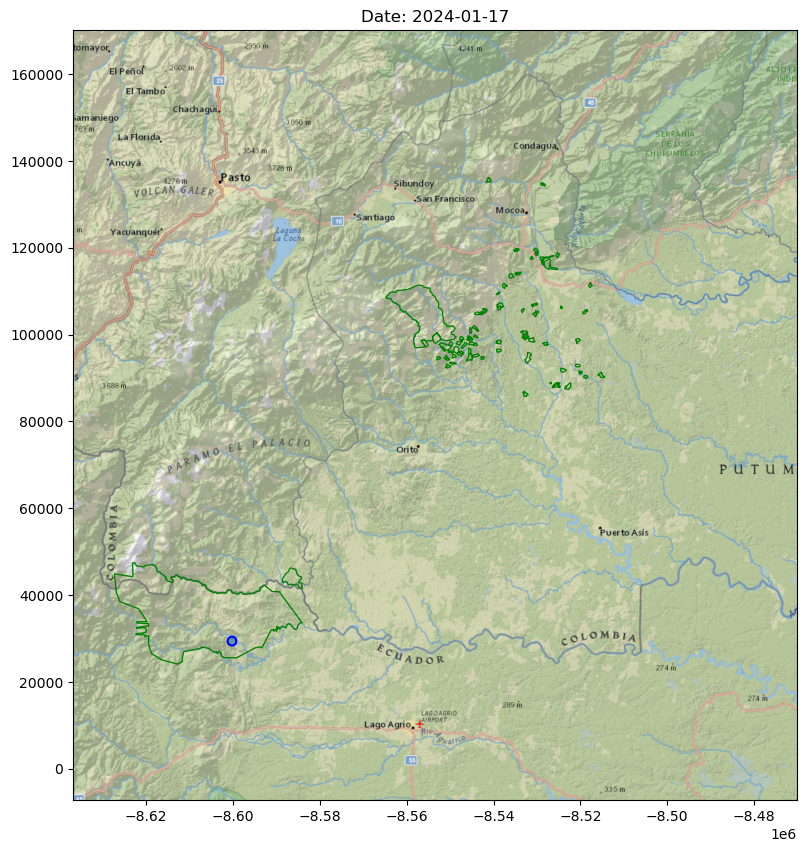

In [12]:
daily_video(daily_score, lands, first_date=None)
insert_log_entry('Raindrops Video:', upload_to_gcs('biocredits-calc', 'raindrops.mp4', 'raindrops.mp4'))

In [7]:
attribution = daily_attibution(daily_score, lands, obs_expanded, crs=6262)
insert_log_entry('Daily Attribution rows:', str(len(attribution)))

In [8]:
attr_month = monthly_attribution(attribution)
insert_log_entry('Monthly Attribution rows:', str(len(attr_month)))

In [9]:
attr_cumm = cummulative_attribution(attr_month, cutdays = 30, start_date=None)
insert_log_entry('Cummulative Attribution rows:', str(len(attr_cumm)))

In [10]:
insert_gdf_to_airtable(attr_cumm.drop(columns='eco_id_list'), 'Cummulative Attribution', insert_geo = False, delete_all=True)
insert_gdf_to_airtable(attr_month.drop(columns='eco_id_list'), 'Monthly Attribution', insert_geo = False, delete_all=True)
#insert_gdf_to_airtable(attribution.reset_index(), 'Daily Attribution', insert_geo = False, delete_all=True)

end_str = datetime.now(colombia_tz).strftime('%Y-%m-%d %H:%M:%S')
insert_log_entry('End time', end_str)

KeyboardInterrupt: 